# Filtros FIR diseñados por el Algoritmo de Cuadrados Mínimos
<img src="./img/logo_UTN.svg" align="right" width="150" /> 

#### Por Mariano Llamedo Soria

### Resumen 

En este notebook se ejemplifica el diseño de filtros FIR mediante el algoritmo de cuadrados mínimos pesados (WLS).

* Análisis de la respuesta en frecuencia: [plot_plantilla](https://pytc2.readthedocs.io/en/latest/autoapi/pytc2/sistemas_lineales/index.html#pytc2.sistemas_lineales.plot_plantilla)
* Funciones de diseño digital [SciPy firls](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.firls.html#scipy.signal.firls), [PyTC2 fir_design_ls](https://pytc2.readthedocs.io/en/latest/autoapi/pytc2/filtros_digitales/index.html#pytc2.filtros_digitales.fir_design_ls)


### Introducción

El algoritmo de cuadrados mínimos (LS, por sus siglas en inglés) es una técnica estadística que se utiliza para encontrar la mejor aproximación de un conjunto de datos minimizando la suma de los cuadrados de las diferencias entre los valores observados y los valores predichos por el modelo. En el contexto de filtros FIR (Finite Impulse Response), el objetivo es diseñar un filtro que minimice el error entre la respuesta del filtro y una respuesta deseada.

Los filtros diseñados mediante el algoritmo de cuadrados mínimos ofrecen una buena aproximación de la respuesta deseada, pero tienden a presentar un comportamiento diferente en comparación con otros métodos, como el algoritmo de Parks-McClellan (PM) ó Remez. El algoritmo de PM minimiza el error **máximo** en la banda de paso y la banda de rechazo, lo que da como resultado un filtro con un comportamiento *equirriple*. En cambio, el LS  **minimiza el error cuadrático medio**, lo que puede llevar a un mayor error en las bandas más alejadas de la frecuencia de corte. Del mismo modo los filtros diseñados por PM exhiben una transición más abrupta entre bandas de paso y atenuación, para un mismo tamaño de filtro. A pesar de los aspectos negativos antedichos, el algoritmo de LS tiene una ventaja substancial: que **no es iterativo y que tiene asegurada la convergencia**, en tanto que se trate de una plantilla de diseño bien definida.


### Formulación teórica

El objetivo es minimizar el error cuadrático entre la respuesta en frecuencia del filtro $ H_R(\Omega) $ y la respuesta deseada $ D(\Omega) $:

$$
\left|E(\Omega)\right|^2 = \sum_{\Omega \in F} \left| D(\Omega) - H_R(\Omega) \right|^2
$$

Como se verá más adelante, este problema se puede resolver de forma práctica mediante álgebra matricial en cualquier lenguaje de programación.

Se define la respuesta deseada $ D(\Omega) $ en la banda de frecuencia, donde $ \Omega $ es la frecuencia angular normalizada (de $ 0 $ a $ \pi $). La respuesta deseada del filtro en frecuencia $ D(\Omega) $ puede definirse como:

$$
D(\Omega) = \begin{cases} 
1 & \text{si } 0 \leq\Omega\leq \Omega_c \\
0 & \text{si } \Omega_c <\Omega\leq 1.0
\end{cases}
$$

veremos ahora cómo definir la respuesta en frecuencia $H_R(\Omega)$

### Respuesta en frecuencia del filtro

Para un filtro FIR de $ L $ coeficientes, la respuesta en frecuencia se puede expresar como:

$$
H(\Omega) = \sum_{k=0}^{L-1} h[k] \cdot e^{-j2\pi\Omega k} = H_R(\Omega) \cdot e^{j \cdot \varphi(\Omega) \cdot k}
$$

De los filtros FIR de tipo $I$ podemos decir que la parte real será:

$$
H_R(\Omega) = h[M] + \sum_{k=1}^{M} 2.h[M-k] \cdot \cos(\pi\Omega k)
$$

y recordando que el módulo  $ \left| H(\Omega) \right| = \left| H_R(\Omega) \right| $. Del mismo modo consideraremos $M = \frac{L-1}{2}$ al punto medio de la respuesta al impulso $h(k)$, que para los FIR tipo $I$ debe ser entero.

Se verá que al querer expresar matricialmente la función objetivo a minimizar, resultará más útil expresar la respuesta:

$$
H_R(\Omega) = \sum_{k=0}^{M} a[M-k] \cdot \cos(\pi\Omega k)
$$


### Formulación matricial del problema

Se comenzará con expresar la respuesta del filtro objetivo de forma matricial, muestreado en $R \gg M$ frecuencias que conforman el conjunto $F=[ \Omega_0, \Omega_1, \dots, \Omega_{R-1}] $ de frecuencias de evaluación:

$$
\mathbf{H_R} =
\begin{bmatrix}
 H_R(\Omega_0) \\
 H_R(\Omega_1) \\
\vdots \\
 H_R(\Omega_{R-1}) \\
\end{bmatrix} = 
\begin{bmatrix}
1 &  \cos(\Omega_0) &  \cos(2\Omega_0) & \dots &  \cos(M\Omega_0)  \\
1 &  \cos(\Omega_1) &  \cos(2\Omega_1) & \dots &  \cos(M\Omega_1) \\
\vdots & \vdots & \vdots & \ddots & \vdots & \vdots \\
1 &  \cos(\Omega_{R-1}) &  \cos(2\Omega_{R-1}) & \dots &  \cos(M\Omega_{R-1}) \\
\end{bmatrix} \cdot
\begin{bmatrix}
a_M \\
a_{M-1} \\
\vdots \\
a_0 \\
\end{bmatrix} = 
\mathbf{C} \cdot \mathbf{a}
$$

del mismo modo el error entre la respuesta deseada y el filtro
$$
\left|E(\Omega)\right|^2 = \sum_{\Omega \in F} \left| D(\Omega) - H_R(\Omega) \right|^2
$$

se puede expresar como

$$
\mathbf{E}^T\mathbf{E} = (\mathbf{D} - \mathbf{H_R})^T (\mathbf{D} - \mathbf{H_R})
$$

ó

$$
\mathbf{E}^T\mathbf{E} = (\mathbf{D} - \mathbf{C} \cdot \mathbf{a})^T (\mathbf{D} - \mathbf{C} \cdot \mathbf{a})
$$

Es decir que el vector de coeficientes $\mathbf{a}$ que minimiza el error cuadrático medio $\mathbf{E}^T\mathbf{E}$, se puede demostrar que resulta equivalente a resolver la ecuación

$$
(\mathbf{C}^T\mathbf{C}) \cdot \mathbf{a} = \mathbf{C}^T \cdot \mathbf{D}
$$

que resulta en que los coeficientes serán:

$$
\mathbf{a} = (\mathbf{C}^T\mathbf{C})^{-1} \cdot  \mathbf{C}^T \cdot  \mathbf{D}
$$


### Ejemplo Numérico

Vamos a llevar a cabo un ejemplo numérico detallado con:

- $ L = 9 $ coeficientes. $L$ será impar para asegurar que el retardo $M = \frac{L-1}{2}$, sea entero.
- **Frecuencia de corte** $ \Omega_c = 0.4 $ (de la frecuencia de Nyquist)

1. Definir las frecuencias de muestreo de las respuestas en frecuencia. Usaremos $R = 4*M$ frecuencias igualmente espaciadas entre 0 y 1.0.

$$
F = \text{linspace}(0, 1.0, R)
$$

2. **Respuesta deseada $ D(\Omega) $**:

$$
D(\Omega) = \begin{cases} 
1 & \text{si }\Omega\leq \Omega_c \\
0 & \text{si }\Omega> \Omega_c
\end{cases}
$$

3. **Construcción de la matriz $ A $**:

Cada fila $ i $ de $ A $ está dada por:

$$
A[i, j] = \cos(2\pi f_i \cdot j)
$$

4. **Resolución del sistema usando mínimos cuadrados**:

$$
\mathbf{h} = \left( A^T A \right)^{-1} A^T \mathbf{D}
$$

Ahora veremos este pequeño ejemplo mediante una **simulación numérica**.

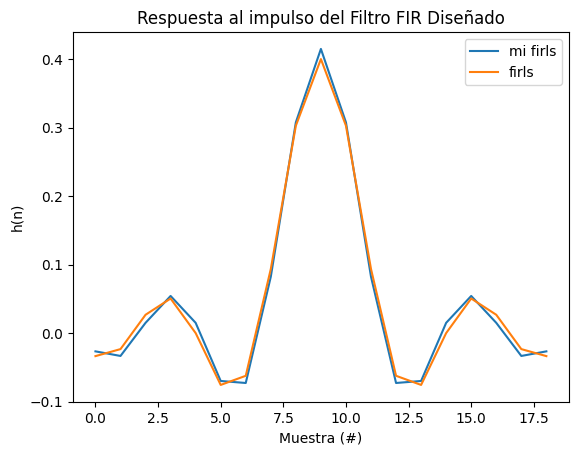

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import firls

# Parámetros del filtro
N = 19  # Número de coeficientes (orden del filtro)
omega_c = 0.4  # Frecuencia de corte normalizada

# punto medio simetría
M = (N-1)//2
# cantidad de puntos donde se calcula la diferencia entre
# la respuesta deseada y la obtenida
R = 4 * M
# Definir frecuencias de muestreo de la respuesta deseada
frecuencias = np.linspace(0, 1.0, R)

# Definir la respuesta deseada
respuesta_deseada = np.where(frecuencias <= omega_c, 1, 0)

# Construir la matriz de diseño A
A = np.zeros((R, M+1))
for i,f in enumerate(frecuencias):
    A[i, :] = np.cos( np.pi * f * np.arange(M+1))

# Resolver el sistema de ecuaciones para los coeficientes únicos
h_half = np.linalg.lstsq(A, respuesta_deseada, rcond=None)[0]

# Crear el filtro completo aplicando la simetría
h = np.concatenate(( 0.5*np.flip(h_half[1:]), 0.5*h_half))
h[M] = 2*h[M]
#h = np.hstack((h_half[:0:-1], 2 * h_half[0], h_half[1:]))

# Generar el filtro usando firls de scipy
# La respuesta deseada en firls debe especificarse para bandas de frecuencia
# En este caso, la banda de paso es [0, 0.2] y la banda de detención es [0.2, 0.5]
h_firls = firls(N, [0, omega_c, omega_c, 1.0], [1, 1, 0, 0], fs=2.0)


# Mostrar los coeficientes
#print("Coeficientes del filtro FIR:")
#print(h)

plt.plot(h, label='mi firls')
plt.plot(h_firls, label='firls')
plt.title("Respuesta al impulso del Filtro FIR Diseñado")
plt.xlabel("Muestra (#)")
plt.ylabel("h(n)")
plt.legend()
plt.show()


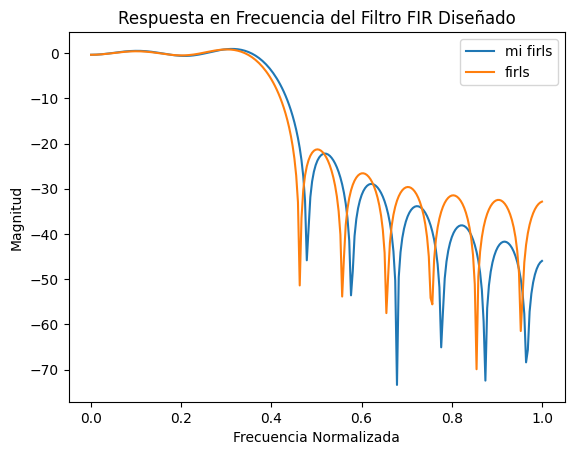

In [2]:
import matplotlib.pyplot as plt

fft_sz = 512
half_fft_sz = fft_sz//2

# Calcular la respuesta en frecuencia del filtro diseñado
H = np.fft.fft(h, fft_sz)
H_firls = np.fft.fft(h_firls, fft_sz)
frecuencias = np.linspace(0, 1.0, half_fft_sz)

# Graficar la respuesta en frecuencia
plt.plot(frecuencias, 20*np.log10(np.abs(H[:half_fft_sz])), label='mi firls')
plt.plot(frecuencias, 20*np.log10(np.abs(H_firls[:half_fft_sz])), label='firls')
plt.title("Respuesta en Frecuencia del Filtro FIR Diseñado")
plt.xlabel("Frecuencia Normalizada")
plt.ylabel("Magnitud")
plt.legend()
plt.show()


Como se puede observar en el ejemplo anterior, una vez formulada la plantilla del filtro, no tenemos otra forma de modificar el filtro obtenido. En este sentido este método se comporta como el basado en ventanas, en caso de no satisfacer la plantilla, lo único que podemos hacer es aumentar el orden del filtro.

En la práctica existen infinidad de problemas donde el orden de un filtro se encuentra fuertemente limitado, no así la atenuación o el ripple de la plantilla. En esos casos, es de agradecer disponer de una forma de optimizar la respuesta del filtro, intercambiando ripple por atenuación, o viceversa. Esto se puede formular matemáticametne como un problema de cuadrados mínimos ponderados, donde el error se pondera mediante una función $W(\Omega)$

$$
\left|E(\Omega)\right|^2 = \sum_{\Omega \in F} W(\Omega) \cdot \left| D(\Omega) - H_R(\Omega) \right|^2
$$

De esta manera logramos ponderar más el error en la banda de paso o en la de detenida, dependiendo la conveniencia.

### Formulación matricial del problema LS ponderado

El problema se resuelve de forma similar, obteniéndose como solución al vector de coeficientes $\mathbf{a}$

$$
\mathbf{a} \cdot \mathbf{C'} = \mathbf{D'}
$$

con 
$$ \mathbf{C'} = \mathbf{C}^T \, \mathbf{W} \, \mathbf{C} $$ 

y 

$$ \mathbf{D'} = \mathbf{C}^T \, \mathbf{W} \,  \mathbf{D}, $$

entonces

$$
\mathbf{a} = (\mathbf{C}^T \, \mathbf{W} \, \mathbf{C})^{-1} \cdot  \mathbf{C}^T \, \mathbf{W} \,  \mathbf{D}
$$

siendo la matriz de ponderación $\mathbf{W}$

$$
\mathbf{W} = \mathrm{diag}(\sqrt{W_k})
$$

una matriz de $R \times R$, en cuya diagonal están los $k-$ésimos pesos para cada frecuencia.

Repetimos el mismo ejemplo, con más ponderación de la banda de *stop*.

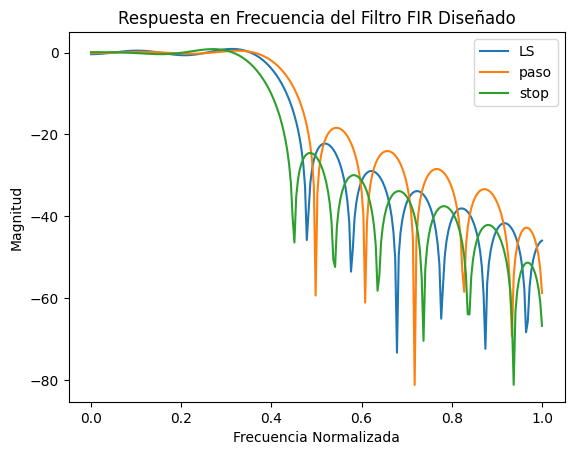

In [3]:
from pytc2.filtros_digitales import fir_design_ls

Ftype = 'm'

Be = [0, 0.4, 0.41, 1.0]
D = [1, 1, 0, 0]

Be_sig = Be
D_sig = [1., 0.]

# enfatizamos stop
W = [1., 50.]

hh_mi_ls_stop = fir_design_ls(order=N, band_edges=Be, desired=D, 
                          weight=W, filter_type = Ftype, 
                          grid_density= 4)

# enfatizamos ripple en paso
W = [50., 1.]

hh_mi_ls_paso = fir_design_ls(order=N, band_edges=Be, desired=D, 
                          weight=W, filter_type = Ftype, 
                          grid_density= 4)

H_mi_ls_stop = np.fft.fft(hh_mi_ls_stop, fft_sz)
H_mi_ls_paso = np.fft.fft(hh_mi_ls_paso, fft_sz)

# Graficar la respuesta en frecuencia
plt.plot(frecuencias, 20*np.log10(np.abs(H[:half_fft_sz])), label='LS')
plt.plot(frecuencias[:half_fft_sz], 20*np.log10(np.abs(H_mi_ls_paso[:half_fft_sz])), label='paso')
plt.plot(frecuencias[:half_fft_sz], 20*np.log10(np.abs(H_mi_ls_stop[:half_fft_sz])), label='stop')

plt.title("Respuesta en Frecuencia del Filtro FIR Diseñado")
plt.xlabel("Frecuencia Normalizada")
plt.ylabel("Magnitud")
plt.legend()
plt.show()


Se observa que la respuesta original LS puede adaptarse según se necesite priorizar alguna parte específica de la plantilla de diseño del filtro.

### Referencias

 [1] T. Holton, *Digital Signal Processing: Principles and Applications*. Cambridge University Press, 2021.

 [2] I. Selesnick. *LINEAR-PHASE FIR FILTER DESIGN BY LEAST SQUARES*. Lecture Notes.
 